In [94]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [177]:
def readfile(file):
    f = open(file, "r")
    if(file[-3:] == 'txt'):
        data = f.readlines()
        dataset = np.zeros((len(data)-2, len(data[2].split('\t'))-1))
        label = np.zeros((len(data)-2))

        for i in range(len(data)-2):
            x = data[i+2].split("\t")
            for j in range(len(x)):
                if j != len(x) - 1:
                    dataset[i][j] = float(x[j])
                else:
                    label[i] = float(x[j][:-1])
    else:
        data = f.readlines()
        n_data = int(len(data)/3)
        dataset = np.zeros((n_data, 2))
        label = np.zeros((n_data, 2))
        j = 0
        count = 0
        for i in range(len(data)):
            if(j == 1):
                dataset[count][0] = float(data[i].split()[0])
                dataset[count][1] = float(data[i].split()[1])
            if(j == 2):
                label[count][0] = int(data[i].split()[0])
                label[count][1] = int(data[i].split()[1])
                count = count + 1
                j = -1
            j += 1
    return dataset, label

def norm(data_r):
    print(data_r)
    data = data_r.copy()
    datanorm = (data - data.min())/(data.max() - data.min()) 
    return datanorm, data.max(), data.min()

def convert_norm(pred,mx,mn):
    return pred*(mx - mn) + mn

def prepare(dataset,label ,percent, epoch):
    data = dataset.copy()
    la = label.copy()
    train_data = []
    test_data = []
    data_with_label =[]
    for i in range(len(data)):
        dataTemp=[]
        dataTemp.append(data[i])
        dataTemp.append(la[i])
        data_with_label.append(dataTemp)
    random.shuffle(data_with_label)
    for i in range(len(data_with_label)):
        if((i%percent) == ((epoch-1)%percent)):
            test_data.append(data_with_label[i])
        else:
            train_data.append(data_with_label[i])
    return train_data,test_data

def setMathix(train_data,test_data):
    train_feature = []
    train_labels = []
    test_feature = []
    test_labels = []

    for i in range(len(train_data)):
        train_feature.append(train_data[i][0])
        train_labels.append(train_data[i][1]) 
    for j in range(len(test_data)):
        test_feature.append(test_data[j][0])
        test_labels.append(test_data[j][1])

    # train_labels_fix = np.zeros((len(train_labels), 1))
    # for i in range(len(train_labels)):
    #     train_labels_fix [i][0] = train_labels[i]
    
    train_feature_fix = np.zeros((len(train_feature), len(train_feature[0]) ))
    for i in range(len(train_feature)):
        for j in range(len(train_feature[0])):
            train_feature_fix [i][j] = train_feature[i][j]

    # test_labels_fix = np.zeros((len(test_labels), 1))
    # for i in range(len(test_labels)):
    #     test_labels_fix [i][0] = test_labels[i]
    
    test_feature_fix = np.zeros((len(test_feature), len(test_feature[0]) ))
    for i in range(len(test_feature)):
        for j in range(len(test_feature[0])):
            test_feature_fix [i][j] = test_feature[i][j]
    train_labels_fix = np.asarray(train_labels)
    test_labels_fix = np.asarray(test_labels)
    return train_feature_fix,train_labels_fix,test_feature_fix,test_labels_fix

In [178]:
def load_data(name):
    is_norm = False
    if(name  == 1):
        dataset,label = readfile("./Flood_dataset.txt")
        dataset,mx_dataset,mn_dataset = norm(dataset)
        label,mx_label,mn_label = norm(label)
        is_norm = True
        max_min = [mx_dataset,mn_dataset,mx_label,mn_label]
    else :
        dataset,label = readfile("./cross.pat")
    n_sample = np.arange(len(dataset))
    np.random.shuffle(n_sample)
    if(is_norm) :
        return dataset,label,n_sample,max_min
    else :
        return dataset,label,n_sample

def dataset_with_crossvalidation_90(dataset,label):
    train_data,test_data = prepare(dataset, label, percent, epochs)
    train_feature,train_labels,test_feature,test_labels = setMathix(train_data,test_data)
    return train_feature,train_labels,test_feature,test_labels

In [179]:
percent = 10
epochs = 500
file1 = "Flood_dataset.txt"
file2 = "cross.pat"


In [185]:
class NN :
    
    def __init__(self,shape,nueral_shape,acti_funct):
        shape[1:1] = nueral_shape 
        self.shape = shape
        self.act_func = acti_funct
        self.weights = self.init_weights(self.shape)
        self.outputs = None
        self.deltas = None
        self.del_old_weights = None
        
    def init_old_weights(self,network_shape):
        weight_arrays = []
        for i in range(0, len(network_shape) - 1):
            cur_idx = i
            next_idx = i + 1
            weight_array = np.zeros((network_shape[next_idx], network_shape[cur_idx]))
            weight_arrays.append(weight_array)
        
        return weight_arrays
    
    def init_weights(self,network_shape):
        weight_arrays = []
        for i in range(0, len(network_shape) - 1):
            cur_idx = i
            next_idx = i + 1
            weight_array = 2*np.random.rand(network_shape[next_idx], network_shape[cur_idx]) - 1
            weight_arrays.append(weight_array)

        return weight_arrays


    def predict(self,sample):
        
        current_input =  (sample.copy()).T
        outputs = []
        for network_weight in self.weights:
            current_output_temp = np.dot(network_weight, current_input)
            current_output = self.acti_funct(current_output_temp)
            outputs.append(current_output)
            current_input = current_output
        
        if(self.shape[-1] == 1) :
            return current_output.T
        else :
            tp = None 
            fp = None 
            for i in range(len(outputs[-1])):
                if( i == 0) :
                    tp = outputs[-1][i]
                else :
                    fp = outputs[-1][i]
                    tp = np.vstack((tp, fp)).T
            return np.argmax(tp, axis=1)
                    
    def train(self,sample, d_out, training_rate,momentum_rate,epoch,show=True):
        # print(type(d_out))
        # print(np.shape(d_out))
        sample_T = (sample.copy()).T
        d_out_T = (d_out.copy()).T
        for i in range(epoch):
            self.FW_NN(sample_T)
            self.BW_NN(d_out_T)
            self.update_weights(sample_T,learning_rate,momentum_rate,i)
            sqe = self.sum_sqaure_error(self.predict(sample),d_out_T)
            if(show and i % 10 == 0):
                print('Epoch : #'+str(i)+',  Sum Square Error : '+str(sqe))
            if sqe < np.finfo(np.float32).eps :
                break
                
    def FW_NN(self,input):

        current_input = input
        outputs = []
        for w in self.weights:
            current_output_tmp = np.dot(w, current_input)
            current_output = self.acti_funct(current_output_tmp)
            outputs.append(current_output)
            current_input = current_output
        self.outputs = outputs
        
    def BW_NN(self,d_out):
        
        deltas = []
        O_error = d_out - self.outputs[len(self.outputs)-1]
        O_delta = O_error *self.derivertive_acti_funct(self.outputs[len(self.outputs)-1])
        deltas.append(O_delta)

        cur_delta = O_delta
        back_idx = len(self.outputs) - 2

        for w in self.weights[::-1][:-1]:
            hidd_error = np.dot(w.T, cur_delta)
            hidd_delta = hidd_error * self.derivertive_acti_funct(self.outputs[back_idx])
            deltas.append(hidd_delta)
            cur_delta = hidd_delta
            back_idx -= 1
            
        self.deltas = deltas
    
    def update_weights(self,sample,learning_rate,momentum_rate,count):
        index_current_weight = len(self.weights) - 1
        current_dels = []
        for d in self.deltas:
            sample_used = None
            if index_current_weight - 1 < 0:
                sample_used = sample
            else:
                sample_used = self.outputs[index_current_weight - 1]
                
            current_delta = learning_rate*np.dot(d, sample_used.T)
            
            if(count == 0) :
                self.weights[index_current_weight] +=  current_delta
            else :
                self.weights[index_current_weight] +=  momentum_rate*self.del_old_weights[index_current_weight]+ current_delta
            index_current_weight -= 1
            current_dels.insert(0, current_delta)
            
        self.del_old_weights = current_dels

    def acti_funct(self,v):
        if self.act_func == 'sigmoid' :
            return 1 / (1 + np.exp(-v))
        if self.act_func == 'tanh' :
            return np.tanh(v)
        if self.act_func == 'linear' :
            return v
        return v

    def derivertive_acti_funct(self,v):
        if self.act_func == 'sigmoid' :
            return v * (1 - v)
        if self.act_func == 'tanh' :
            return 1 - (v ** 2)
        if self.act_func == 'linear' :
            return 1
        return v

        
    def sum_sqaure_error(self,pred,real):
        real_m = real.copy()
        sums = 0
        if(real.ndim > 1) :
            tp = None 
            fp = None 
            for i in range(len(real_m)):
                if( i == 0) :
                    tp = real_m[i]
                else :
                    fp = real_m[i]
                    tp = np.vstack((tp, fp)).T
            real_m = np.argmax(tp, axis=1)
        for i in range(len(pred)):
            sums = sums + np.square(pred[i]-real_m[i])
        return sums/2

    def conf_matrix(self,pred,true,is_norm=False,confuse=True,Table=True):
        true_m = np.zeros(len(true))
        if(true.ndim > 1) :
            for i in range(len(true)):
                true_m[i] = np.argmax(true[i], axis=0)
        if(is_norm):
            sqr_error = 0 
            if(Table):
                print('Desired Output\t\t|\tPredict\t\t\t|\tError')
                print('-----------------------------------------------------------------------------')
            for i in range(len(true)):
                error = round(true[i] - round(pred[i][0],8),2)
                if(Table):
                    print(str(int(true[i]))+'\t\t\t\t|\t'+str(format(round(pred[i][0],8), '.8f'))+'\t\t|\t'+str(error))
                sqr_error = sqr_error + (error * error)
            if(Table):
                print('-----------------------------------------------------------------------------')
                print('\t\t Sum Square Error = '+str(round(sqr_error/len(true),6)))
                print('=======================================')
            return round(sqr_error/len(true),6)
        else :
            if(Table):
                print('Desired Output\t\t|\tPredict\t\t\t')
                print('------------------------------------------------')
                for i in range(len(true)):
                    print(str(int(true_m[i]))+'\t\t\t\t|\t'+str(pred[i]))
                print('------------------------------------------------')
        if(confuse):
            print('\n\t\t Confusion Matrix')
            TP = 0
            FN = 0
            FP = 0
            TN = 0
            for i in range(len(true)):
                if((pred[i] == 0) and ( true_m[i] == 0)):
                    TN = TN + 1 
                elif((pred[i] == 1) and ( true_m[i] == 1)):
                    TP = TP + 1
                elif((pred[i] == 1) and ( true_m[i] == 0)):
                    FP = FP + 1
                else :
                    FN = FN + 1

            print(' ----------------------------------------')
            for i in range(8):
                print('|\t\t\t|\t\t\t|')
                if(i == 1):
                    print('|\t    '+str(TN)+'\t\t|\t    '+str(FP)+'\t\t|\t '+str(FP+TN))
                if(i == 3):
                    print(' ----------------------------------------')
                if(i == 5):
                    print('|\t    '+str(FN)+'\t\t|\t    '+str(TP)+'\t\t|\t '+str(FN+TP))
            print(' ----------------------------------------')
            print(' \t    '+str(TN+FN)+'\t\t       '+str(FP+TP)+'\t\t\t'+str(TN+FP+FN+TP))
            print('')
            print('Accuracy : '+str((TN+TP)/(TN+FP+FN+TP)))
            return((TN+TP)/(TN+FP+FN+TP))

In [187]:
def MLP(layer,learning_rate,momentum_rate,activation,epoch,data_num) :
    if(data_num == 0):
        print('------------------- Variable -------------------\n')
        dataset,label,n_sample = load_data(data_num)
        data_name = 'cross.pat'
    else :
        print('-------------------------------- Variable --------------------------------\n')
        dataset,label,n_sample,max_min = load_data(data_num)
        data_name = 'Flood data set'
    print('Datafile : ' +str(data_name),end='\n')
    print('layer number: '+str(len(dataset[0]))+'-',end='')
    for i in range(len(layer)):
        print(str(layer[i])+'-',end='')
    print(label.ndim,end='\n')
    print('Learning rate : '+str(learning_rate),end='\n')
    print('Momentum rate : '+str(momentum_rate),end='\n')
    print('Activaion Function : ' +str(activation),end='\n')
    print('Cross validation : 90',end='\n')
    print('#Epoch : '+str(epoch),end='\n')
    error_avg = []
    acc_avg = []
    for i in range(10):
        # test_data = n_sample[i*n_test_per_round:i*n_test_per_round+n_test_per_round]
        # train_data = list(set(n_sample) - set(test_data))
        train_feature,train_labels,test_feature,test_labels = dataset_with_crossvalidation_90(dataset,label)
        nn = NN([len(dataset[0]),label.ndim],layer,activation)
        nn.train(train_feature,train_labels,learning_rate,momentum_rate,epoch,False)
        pred = nn.predict(test_feature)
        if(data_num == 1):
#             print('\n-------------------------------- Round : '+str(i)+' --------------------------------')
            pred = convert_norm(pred,max_min[2],max_min[3])
            test_label = convert_norm(test_labels,max_min[2],max_min[3])
            error_avg.append(nn.conf_matrix(pred,test_label,is_norm=True,confuse=False,Table=True))
        else :
#             print('\n----------------- Round : '+str(i)+' -----------------')
            acc_avg.append(nn.conf_matrix(pred,test_labels,is_norm=False,confuse=True,Table=True))
    if(data_num == 1):
        print('\n********  Sum Square Error Average : ' + str(round(np.sum(error_avg)/len(error_avg),4))+'  *********')
        print(np.min(error_avg))
        return round(np.sum(error_avg)/len(error_avg),4),np.min(error_avg)
    else :
        print('\n********  Accuracy Average : ' + str(round(np.sum(acc_avg)/len(acc_avg),4))+'  *********')
        return round(np.sum(acc_avg)/len(acc_avg),4),np.max(acc_avg)

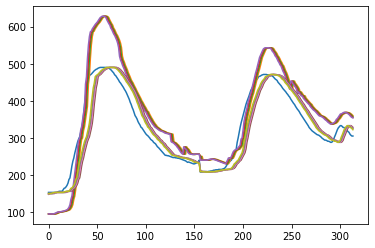

In [191]:
# Visualization Flood_dataset.txt
dataset, label = readfile("./Flood_dataset.txt")
plt.plot(label, label="Y")
plt.plot(dataset)
plt.show()

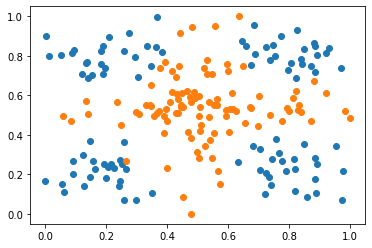

In [192]:
# Visualization cross.pat
dataset, label = readfile("./cross.pat")

setAx = []
setAy = []
setBx = []
setBy = []

for i in range(len(label)):
    if label[i][0] == 1:
        setAx.append(dataset[i][0])
        setAy.append(dataset[i][1])
    if label[i][0] == 0:
        setBx.append(dataset[i][0])
        setBy.append(dataset[i][1])

plt.scatter(setAx, setAy, label='SetA')
plt.scatter(setBx, setBy, label='SetB')

-------------------------------- Variable --------------------------------

[[ 95.  95.  95. ... 149. 150. 150.]
 [ 95.  95.  95. ... 150. 150. 150.]
 [ 95.  95.  95. ... 150. 150. 150.]
 ...
 [365. 363. 360. ... 331. 328. 328.]
 [363. 360. 357. ... 328. 328. 325.]
 [360. 357. 355. ... 328. 325. 322.]]
[153. 153. 153. 153. 153. 153. 153. 153. 153. 154. 155. 156. 156. 156.
 156. 160. 164. 165. 168. 172. 178. 188. 192. 207. 224. 237. 246. 259.
 270. 280. 290. 297. 303. 314. 326. 340. 362. 390. 412. 435. 447. 465.
 468. 470. 472. 475. 478. 481. 483. 485. 486. 488. 489. 490. 490. 490.
 490. 490. 490. 490. 490. 489. 488. 486. 484. 481. 478. 475. 470. 468.
 464. 460. 456. 451. 448. 444. 440. 436. 431. 427. 422. 416. 410. 404.
 396. 390. 382. 376. 368. 360. 356. 351. 344. 339. 335. 329. 327. 323.
 319. 315. 311. 308. 306. 303. 300. 296. 294. 292. 288. 286. 284. 280.
 276. 274. 271. 268. 265. 262. 259. 256. 253. 253. 252. 252. 251. 250.
 249. 248. 247. 247. 247. 246. 246. 245. 245. 244. 243. 2

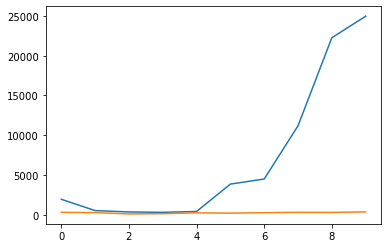

In [193]:
# Find best layer for Flood_dataset.txt
error_arr = np.zeros(10)
minn_arr = np.zeros(10)
for i in range(1,11):
    layer = [(2+(i*2)),(1+(i*2))] 
    data_num = 1 # 0 = cross.pat , 1 = flood data set
    learning_rate = 0.15
    momentum_rate = 0.2
    activation = 'sigmoid'
    epoch = 1000
    error,minn = MLP(layer,learning_rate,momentum_rate,activation,epoch,data_num)
    error_arr[i-1] = error
    minn_arr[i-1] = minn

plt.plot(error_arr, label="Error Avg")
plt.plot(minn_arr, label="Min Error")
plt.show()

------------------- Variable -------------------

Datafile : cross.pat
layer number: 2-4-3-2
Learning rate : 0.15
Momentum rate : 0.2
Activaion Function : sigmoid
Cross validation : 90
#Epoch : 1000
Desired Output		|	Predict			
------------------------------------------------
1				|	0
0				|	0
1				|	1
0				|	1
0				|	0
1				|	1
1				|	1
0				|	0
0				|	0
0				|	0
0				|	1
1				|	1
1				|	0
0				|	0
1				|	1
0				|	1
0				|	0
1				|	0
1				|	1
1				|	1
------------------------------------------------

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    3		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    7		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    10		       10			20

Accuracy : 0.7
Desired Output		|	Predict			
------------------------------------------------
0				|	0
0				|	0
0				|	1
1				|	1
1				|	1
1				|	1
1				|	1
1				|	1
1				|	0
0				|	0
0				|	0
0

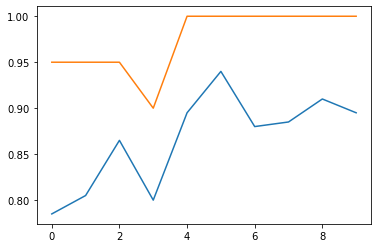

In [194]:
# Find best layer for cross.pat
error_arr = np.zeros(10)
minn_arr = np.zeros(10)
for i in range(1,11):
    layer = [(2+(i*2)),(1+(i*2))] 
    data_num = 0 # 0 = cross.pat , 1 = flood data set
    learning_rate = 0.15
    momentum_rate = 0.2
    activation = 'sigmoid'
    epoch = 1000
    error,minn = MLP(layer,learning_rate,momentum_rate,activation,epoch,data_num)
    error_arr[i-1] = error
    minn_arr[i-1] = minn

plt.plot(error_arr, label="Error Avg")
plt.plot(minn_arr, label="Min Error")
plt.show()

-------------------------------- Variable --------------------------------

[[ 95.  95.  95. ... 149. 150. 150.]
 [ 95.  95.  95. ... 150. 150. 150.]
 [ 95.  95.  95. ... 150. 150. 150.]
 ...
 [365. 363. 360. ... 331. 328. 328.]
 [363. 360. 357. ... 328. 328. 325.]
 [360. 357. 355. ... 328. 325. 322.]]
[153. 153. 153. 153. 153. 153. 153. 153. 153. 154. 155. 156. 156. 156.
 156. 160. 164. 165. 168. 172. 178. 188. 192. 207. 224. 237. 246. 259.
 270. 280. 290. 297. 303. 314. 326. 340. 362. 390. 412. 435. 447. 465.
 468. 470. 472. 475. 478. 481. 483. 485. 486. 488. 489. 490. 490. 490.
 490. 490. 490. 490. 490. 489. 488. 486. 484. 481. 478. 475. 470. 468.
 464. 460. 456. 451. 448. 444. 440. 436. 431. 427. 422. 416. 410. 404.
 396. 390. 382. 376. 368. 360. 356. 351. 344. 339. 335. 329. 327. 323.
 319. 315. 311. 308. 306. 303. 300. 296. 294. 292. 288. 286. 284. 280.
 276. 274. 271. 268. 265. 262. 259. 256. 253. 253. 252. 252. 251. 250.
 249. 248. 247. 247. 247. 246. 246. 245. 245. 244. 243. 2

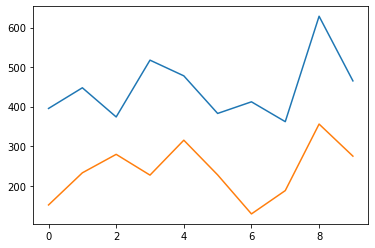

In [195]:
# Find best learning rate for Flood_dataset.txt
error_arr = np.zeros(10)
minn_arr = np.zeros(10)
for i in range(1,11):
    layer = [6,5] 
    data_num = 1 # 0 = cross.pat , 1 = flood data set
    learning_rate = (0.01*i)+0.1
    momentum_rate = 0.2
    activation = 'sigmoid'
    epoch = 1000
    error,minn = MLP(layer,learning_rate,momentum_rate,activation,epoch,data_num)
    error_arr[i-1] = error
    minn_arr[i-1] = minn

plt.plot(error_arr, label="Error Avg")
plt.plot(minn_arr, label="Min Error")
plt.show()

------------------- Variable -------------------

Datafile : cross.pat
layer number: 2-6-5-2
Learning rate : 0.11
Momentum rate : 0.2
Activaion Function : sigmoid
Cross validation : 90
#Epoch : 1000
Desired Output		|	Predict			
------------------------------------------------
0				|	0
1				|	1
0				|	0
0				|	1
1				|	0
0				|	0
1				|	1
1				|	0
0				|	1
1				|	0
1				|	0
1				|	1
1				|	0
1				|	1
0				|	0
1				|	1
1				|	1
0				|	1
0				|	0
1				|	1
------------------------------------------------

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    3		|	 8
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    7		|	 12
|			|			|
|			|			|
 ----------------------------------------
 	    10		       10			20

Accuracy : 0.6
Desired Output		|	Predict			
------------------------------------------------
0				|	0
0				|	0
1				|	1
1				|	1
1				|	1
1				|	1
1				|	1
1				|	1
1				|	1
1				|	1
0				|	0
1	

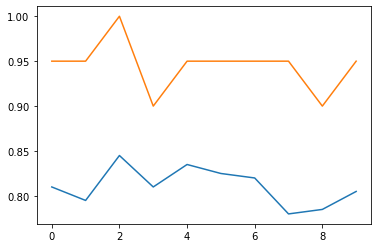

In [196]:
# Find best learning rate for cross.pat
error_arr = np.zeros(10)
minn_arr = np.zeros(10)
for i in range(1,11):
    layer = [6,5] 
    data_num = 0 # 0 = cross.pat , 1 = flood data set
    learning_rate = (0.01*i)+0.1
    momentum_rate = 0.2
    activation = 'sigmoid'
    epoch = 1000
    error,minn = MLP(layer,learning_rate,momentum_rate,activation,epoch,data_num)
    error_arr[i-1] = error
    minn_arr[i-1] = minn

plt.plot(error_arr, label="Error Avg")
plt.plot(minn_arr, label="Min Error")
plt.show()

-------------------------------- Variable --------------------------------

[[ 95.  95.  95. ... 149. 150. 150.]
 [ 95.  95.  95. ... 150. 150. 150.]
 [ 95.  95.  95. ... 150. 150. 150.]
 ...
 [365. 363. 360. ... 331. 328. 328.]
 [363. 360. 357. ... 328. 328. 325.]
 [360. 357. 355. ... 328. 325. 322.]]
[153. 153. 153. 153. 153. 153. 153. 153. 153. 154. 155. 156. 156. 156.
 156. 160. 164. 165. 168. 172. 178. 188. 192. 207. 224. 237. 246. 259.
 270. 280. 290. 297. 303. 314. 326. 340. 362. 390. 412. 435. 447. 465.
 468. 470. 472. 475. 478. 481. 483. 485. 486. 488. 489. 490. 490. 490.
 490. 490. 490. 490. 490. 489. 488. 486. 484. 481. 478. 475. 470. 468.
 464. 460. 456. 451. 448. 444. 440. 436. 431. 427. 422. 416. 410. 404.
 396. 390. 382. 376. 368. 360. 356. 351. 344. 339. 335. 329. 327. 323.
 319. 315. 311. 308. 306. 303. 300. 296. 294. 292. 288. 286. 284. 280.
 276. 274. 271. 268. 265. 262. 259. 256. 253. 253. 252. 252. 251. 250.
 249. 248. 247. 247. 247. 246. 246. 245. 245. 244. 243. 2

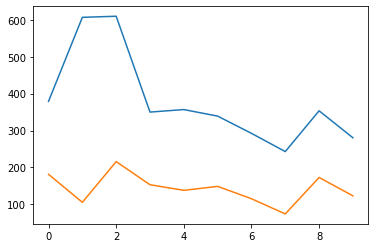

In [197]:
# Find best momentum rate for Flood_dataset.txt
error_arr = np.zeros(10)
minn_arr = np.zeros(10)
for i in range(1,11):
    layer = [6,5] 
    data_num = 1 # 0 = cross.pat , 1 = flood data set
    learning_rate = 0.15
    momentum_rate = (0.01*i)+0.2
    activation = 'sigmoid'
    epoch = 1000
    error,minn = MLP(layer,learning_rate,momentum_rate,activation,epoch,data_num)
    error_arr[i-1] = error
    minn_arr[i-1] = minn

plt.plot(error_arr, label="Error Avg")
plt.plot(minn_arr, label="Min Error")
plt.show()

------------------- Variable -------------------

Datafile : cross.pat
layer number: 2-6-5-2
Learning rate : 0.15
Momentum rate : 0.21000000000000002
Activaion Function : sigmoid
Cross validation : 90
#Epoch : 1000
Desired Output		|	Predict			
------------------------------------------------
0				|	0
0				|	0
0				|	0
0				|	0
1				|	1
1				|	1
0				|	0
0				|	0
1				|	0
1				|	1
1				|	0
0				|	0
1				|	1
1				|	0
1				|	0
0				|	0
0				|	0
1				|	1
1				|	1
0				|	0
------------------------------------------------

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    10		|	    0		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    4		|	    6		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    14		       6			20

Accuracy : 0.8
Desired Output		|	Predict			
------------------------------------------------
0				|	0
0				|	0
0				|	0
1				|	1
0				|	0
0				|	0
0				|	1
0				|	0
1				|	1
1		

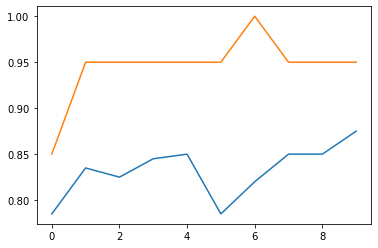

In [198]:
# Find best momentum rate for cross.pat
error_arr = np.zeros(10)
minn_arr = np.zeros(10)
for i in range(1,11):
    layer = [6,5] 
    data_num = 0 # 0 = cross.pat , 1 = flood data set
    learning_rate = 0.15
    momentum_rate = (0.01*i)+0.2
    activation = 'sigmoid'
    epoch = 1000
    error,minn = MLP(layer,learning_rate,momentum_rate,activation,epoch,data_num)
    error_arr[i-1] = error
    minn_arr[i-1] = minn

plt.plot(error_arr, label="Error Avg")
plt.plot(minn_arr, label="Min Error")
plt.show()